In [84]:
import tensorflow as tf  # Import TensorFlow as 'tf'
keras = tf.keras          # Import Keras from TensorFlow as 'keras'
from keras import Sequential, Input  # Import Sequential and Input from Keras
from keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, MaxPooling2D  # Import specific layers
import pandas as pd  # Import pandas for data manipulation
import numpy as np   # Import NumPy for numerical operations
import seaborn as sns  # Import Seaborn for data visualization
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from keras.preprocessing.image import array_to_img, img_to_array, load_img  # Additional image processing
from keras.optimizers import Adam  # Import the Adam optimizer
from keras.utils import plot_model  # Import the plot_model function
import os  # Import os for file system interaction
from keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0, InceptionV3  # Pre-trained models


In [85]:
dir='/kaggle/input/final-railway-dataset/images/*'
img_dir=tf.data.Dataset.list_files(dir,shuffle=True)

In [86]:
def class_def(lab):
    a=str(lab).split("'")[1].split('_')
    lab=''.join(a)
    return lab.split('.')[0]

In [87]:
def get_label(path):
    parts = tf.strings.split(path, '_')
    label = tf.strings.reduce_join(parts[4:7], separator='_')
    return label
classes = img_dir.map(get_label)
unique_classes = classes.apply(tf.data.experimental.unique())
unique_classes_list = list(unique_classes.as_numpy_iterator())
unique_classes_list.sort()
unique_classes_list = [class_def(item) for item in unique_classes_list]
unique_classes_list

['IDB',
 'IDG',
 'IDM',
 'ITB',
 'ITG',
 'ITM',
 'IWB',
 'IWG',
 'IWM',
 'WDB',
 'WDG',
 'WDM',
 'WTB',
 'WTG',
 'WTM',
 'WWB',
 'WWG',
 'WWM']

In [88]:
table_init = tf.lookup.KeyValueTensorInitializer(unique_classes_list, tf.range(len(unique_classes_list)))
table = tf.lookup.StaticHashTable(table_init, default_value=-1)

In [89]:
def preprocess_img(path):
    label_name = get_label(path)
    label_idx = table.lookup(label_name)
    img = tf.io.read_file(path)
    try:
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])
        img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    except tf.errors.InvalidArgumentError:
        img = tf.constant(0.0, shape=[256, 256, 3], dtype=tf.float32)  # Placeholder for invalid images
    return img, label_idx


In [90]:
data=img_dir.map(preprocess_img)

In [91]:
print(unique_classes_list)
print(len(unique_classes_list))

['IDB', 'IDG', 'IDM', 'ITB', 'ITG', 'ITM', 'IWB', 'IWG', 'IWM', 'WDB', 'WDG', 'WDM', 'WTB', 'WTG', 'WTM', 'WWB', 'WWG', 'WWM']
18


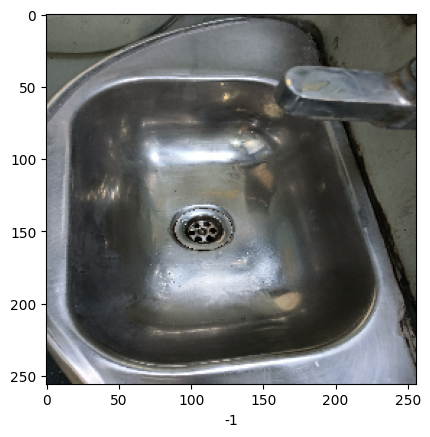

In [92]:
for img,label in data.take(1):
    plt.imshow(img)
    plt.xlabel(label.numpy())

In [93]:
for img,label in data.take(1):
    print(img.shape)

(256, 256, 3)


In [94]:
train=data.take(int(.8*len(data)))
valid=data.skip(int(.8*len(data)))
test=valid.skip(int(.1*len(data)))
valid=valid.take(int(.1*len(data)))
print(len(train))
print(len(test))
print(len(valid))

3115
390
389


In [95]:
train=train.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test=test.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
valid=valid.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [96]:
train=train.batch(32)
test=test.batch(32)
valid=valid.batch(32)


In [97]:
from keras.optimizers import Adam  # Import the Adam optimizer
from keras.applications import InceptionV3  # Pre-trained models


In [28]:
google_model = InceptionV3(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
google_model.trainable = False
google_model.summary()
custom_google_model = Sequential([
    google_model,
    Flatten(),
    Dense(len(unique_classes_list),activation='softmax')
])
custom_google_model.summary()
custom_google_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['acc'])

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 125, 125,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 125, 125,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 62, 62,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 62, 62,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 60, 60,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [29]:
google_history = custom_google_model.fit(train, epochs=15, validation_data=valid)

Epoch 1/15
 1/98 ━━━━━━━━━━━━━━━━━━━━ 2:51:43 106s/step - acc: 0.0312 - loss: 3.6525

I0000 00:00:1720699369.705843     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720699369.758997     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3364 - loss: 2.2715

Invalid SOS parameters for sequential JPEG
W0000 00:00:1720699783.733657     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - acc: 0.3372 - loss: 2.2678 - val_acc: 0.7301 - val_loss: 0.9169
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - acc: 0.7653 - loss: 0.6760 - val_acc: 0.7815 - val_loss: 0.6974
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - acc: 0.8640 - loss: 0.4195 - val_acc: 0.8380 - val_loss: 0.5637
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - acc: 0.9281 - loss: 0.2875 - val_acc: 0.8920 - val_loss: 0.4217
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - acc: 0.9546 - loss: 0.2034 - val_acc: 0.8946 - val_loss: 0.3875
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - acc: 0.9632 - loss: 0.1796 - val_acc: 0.8740 - val_loss: 0.4438
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - acc: 0.9623 - loss: 0.1981 - val_acc: 0.8843 - val_loss: 0.4339
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - acc: 0.9602 - loss: 0.1852 - val_acc: 0.8869 - val_loss: 0.4821
Epoch 9/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - acc: 0.9685 - loss: 0.

In [30]:
custom_google_model.evaluate(test)

Invalid SOS parameters for sequential JPEG


13/13 ━━━━━━━━━━━━━━━━━━━━ 236s 849ms/step - acc: 0.9006 - loss: 0.4351


[0.47004908323287964, 0.9051281809806824]

In [99]:
def predict(im):
    pred=unique_classes_list[np.argmax(custom_google_model.predict(tf.expand_dims(im,axis=0)))]
    confidence=round(np.max(custom_google_model.predict(tf.expand_dims(im,axis=0)))*100,2)
    return pred,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


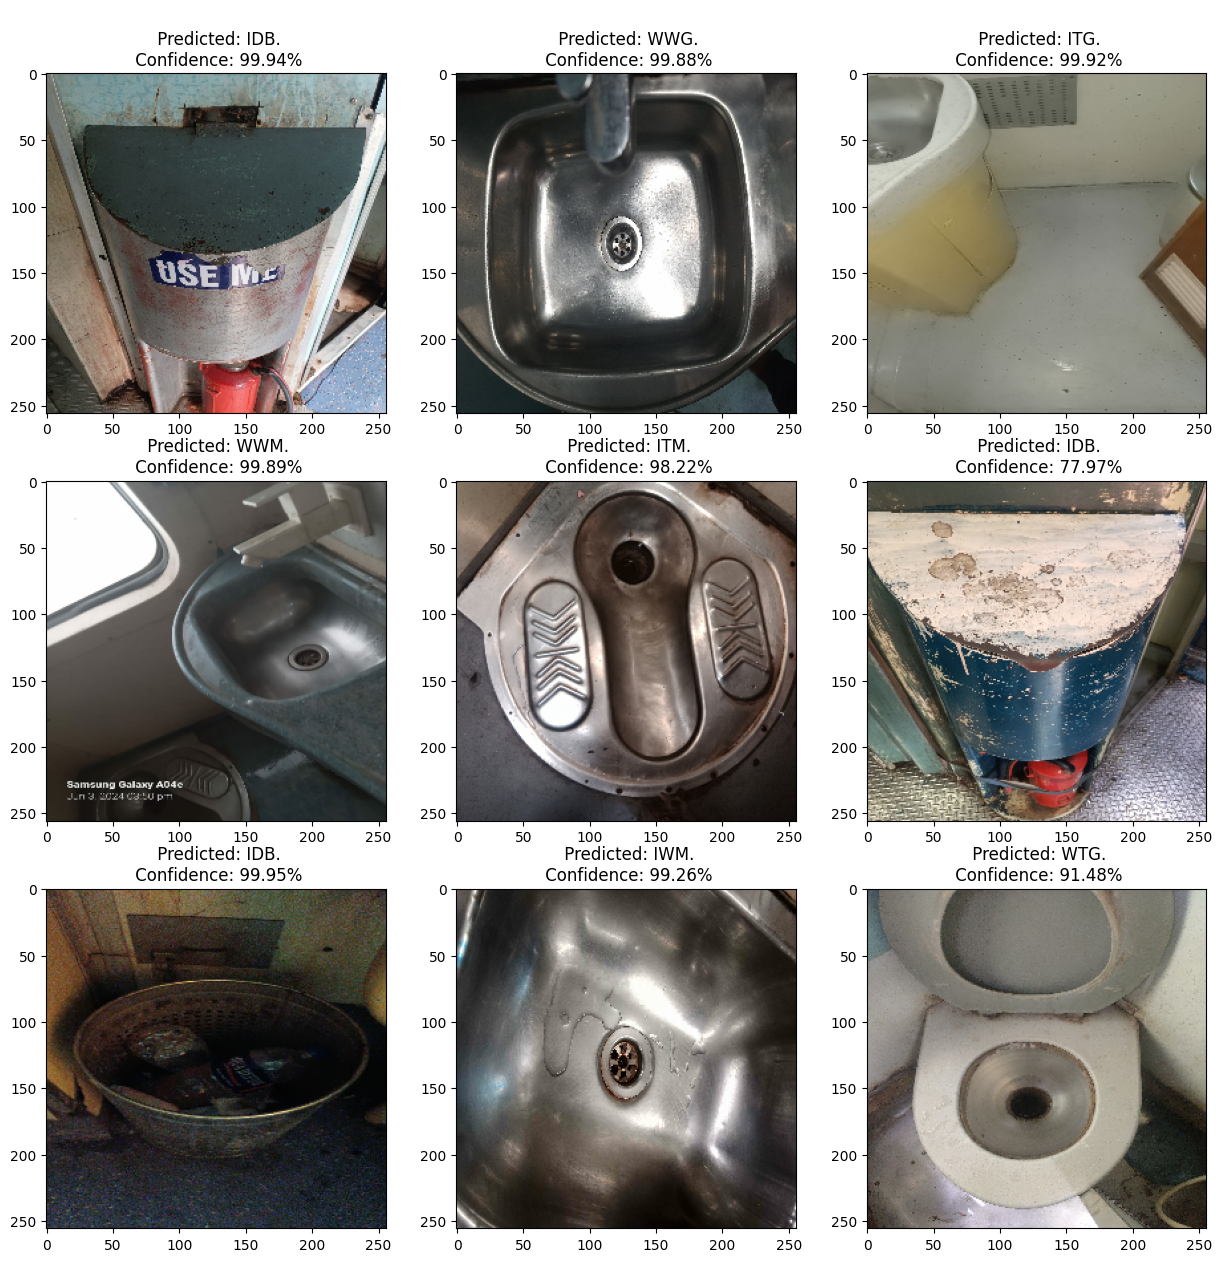

In [112]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        actual_class=unique_classes_list[labels[i]]
        predicted_class,c=predict(images[i])
        plt.title(f"\n Predicted: {predicted_class}.\n Confidence: {c}%")